## Usage example of EiopaDB

First generate a fresh database built using latest source code:

In [1]:
# Check your environment
import sys
sys.path

['C:\\Users\\peter\\PycharmProjects\\solvency2-data',
 'c:\\users\\peter\\appdata\\local\\programs\\python\\python38\\python38.zip',
 'c:\\users\\peter\\appdata\\local\\programs\\python\\python38\\DLLs',
 'c:\\users\\peter\\appdata\\local\\programs\\python\\python38\\lib',
 'c:\\users\\peter\\appdata\\local\\programs\\python\\python38',
 '',
 'C:\\Users\\peter\\AppData\\Roaming\\Python\\Python38\\site-packages',
 'c:\\users\\peter\\appdata\\local\\programs\\python\\python38\\lib\\site-packages',
 'c:\\users\\peter\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\win32',
 'c:\\users\\peter\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\win32\\lib',
 'c:\\users\\peter\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\Pythonwin',
 'c:\\users\\peter\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\peter\\.ipython']

In [2]:
from solvency2_data.eiopa_data import get_workspace
from solvency2_data.sqlite_handler import EiopaDB
database = get_workspace()['database']
db = EiopaDB(database)

DB initialised


In [ ]:
# Hard reset of DB - deletes the file and all stored data and rebuilds empty DB
db.reset()

Now populate it for every month (until July 2021)

In [ ]:
from solvency2_data.eiopa_data import full_rebuild
full_rebuild()

Now this can be indirectly queried using the API

In [3]:
import solvency2_data
from datetime import date
ref_date = date(2020,12,31)
rfr = solvency2_data.get(ref_date)
meta = solvency2_data.get(ref_date, 'meta')
spr = solvency2_data.get(ref_date, 'spreads')
gov = solvency2_data.get(ref_date, 'govies')
sym_adj =  solvency2_data.get(ref_date, 'sym_adj')
rfr.head()

DB initialised
DB initialised
DB initialised
DB initialised


,scenario,currency_code,duration,spot
0,base,CHF,1,-0.00830
1,base,CHF,2,-0.00810
2,base,CHF,3,-0.00777
3,base,CHF,4,-0.00728
4,base,CHF,5,-0.00662


Or directly queried

In [4]:
import pandas as pd
sql = "SELECT * FROM rfr"
df = pd.read_sql(sql, con=db.conn)
df = df.loc[df.scenario=='base',['currency_code','ref_date', 'duration', 'spot']]
df.head()

,currency_code,ref_date,duration,spot
0,CHF,2016-01-31,1,-0.00860
1,CHF,2016-01-31,2,-0.00862
2,CHF,2016-01-31,3,-0.00825
3,CHF,2016-01-31,4,-0.00734
4,CHF,2016-01-31,5,-0.00623


In [5]:
month_list = df.ref_date.drop_duplicates().to_list()
month_list[:5]

['2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31']

In [6]:
df['ref_date'] = df.ref_date.apply(lambda x: month_list.index(x))
df.head()

,currency_code,ref_date,duration,spot
0,CHF,0,1,-0.00860
1,CHF,0,2,-0.00862
2,CHF,0,3,-0.00825
3,CHF,0,4,-0.00734
4,CHF,0,5,-0.00623


In [7]:
eurs = df.loc[df.currency_code=='EUR', ['ref_date', 'duration', 'spot']].set_index('ref_date')
gbps = df.loc[df.currency_code=='GBP', ['ref_date', 'duration', 'spot']].set_index('ref_date')
chfs = df.loc[df.currency_code=='CHF', ['ref_date', 'duration', 'spot']].set_index('ref_date')
usds = df.loc[df.currency_code=='USD', ['ref_date', 'duration', 'spot']].set_index('ref_date')
eurs.head()

,duration,spot
ref_date,,
0,1,-0.00254
0,2,-0.00275
0,3,-0.00223
0,4,-0.00135
0,5,-0.00023


In [9]:
list(eurs.loc[66, 'spot'].values)[:5]

[-0.00612, -0.00594, -0.00556, -0.00513, -0.00462]

## Now have some fun :p

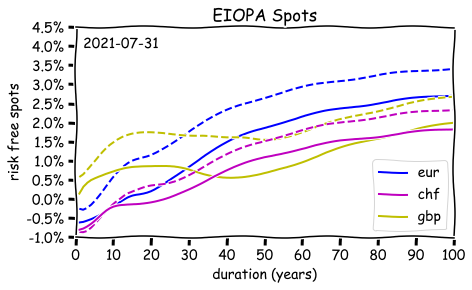

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import matplotlib.ticker as mtick
from IPython.display import HTML

# plt.style.use('ggplot')
plt.xkcd()

fig, ax = plt.subplots(figsize=(7, 4))
ax.set(xlim=(0, 100), ylim=(-0.01, 0.04))

date_text = ax.text(0.02, 0.9, '', transform=ax.transAxes)
#plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.title('EIOPA Spots')

x = list(range(1,151))
#plt.xticks(ticks = x)
plt.xlabel('duration (years)')
plt.locator_params(axis='x', nbins=10)

percentage = np.array(list(map("{:.1%}".format, 0.005 * np.arange(-2, 10))))
plt.yticks(ticks=0.005 * np.arange(-2, 10), labels=percentage)
plt.ylabel('risk free spots')

date_text.set_text(month_list[0])

eur_start = ax.plot(x, eurs.loc[0,'spot'].values, color='b', ls='dashed', lw=2)[0]
eur_line = ax.plot(x, eurs.loc[0,'spot'].values, color='b', lw=2)[0]

gbp_start = ax.plot(x, gbps.loc[0, 'spot'].values, color='y', ls='dashed', lw=2)[0]
gbp_line = ax.plot(x, gbps.loc[0, 'spot'].values, color='y', lw=2)[0]

chf_start = ax.plot(x, chfs.loc[0, 'spot'].values, color='m', ls='dashed', lw=2)[0]
chf_line = ax.plot(x, chfs.loc[0, 'spot'].values, color='m', lw=2)[0]

ax.legend((eur_line, chf_line, gbp_line), ('eur', 'chf', 'gbp'), loc='lower right')
def animate(i):
    key = min(i, 66)
    date_text.set_text(month_list[key])
    eur_line.set_ydata(list(eurs.loc[key, 'spot'].values))
    gbp_line.set_ydata(list(gbps.loc[key, 'spot'].values))
    chf_line.set_ydata(list(chfs.loc[key, 'spot'].values))

anim = FuncAnimation(
    fig, animate, interval=100, frames=67 + 15)

plt.draw()
#plt.show()
HTML(anim.to_html5_video())